- http://matthewrocklin.com/blog/work/2017/03/28/dask-xgboost
- https://examples.dask.org/machine-learning/xgboost.html#Learn-more

In [1]:
PRFX='0315_1'

# setup

In [2]:
from pathlib import Path
import dask.dataframe as dd
import dask.array as da
import pandas as pd
from dask_ml.model_selection import train_test_split
import dask
print('dask.__version__', dask.__version__)
import xgboost
import dask_xgboost
from dask.distributed import Client
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
import glob
import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

cols=[
'text_tokens',
'hashtags',
'tweet_id',
'present_media',
'present_links',
'present_domains',
'tweet_type',
'language',
'timestamp',

'engaged_user_id',
'engaged_follower_count',
'engaged_following_count',
'engaged_is_verified',
'engaged_account_creation_time',

'engaging_user_id',
'engaging_follower_count',
'engaging_following_count',
'engaging_is_verified',
'engaging_account_creation_time',

'engagee_follows_engager',
'reply_engagement_timestamp',
'retweet_engagement_timestamp',
'retweet_with_comment_engagement_timestamp',
'like_engagement_timestamp',
]

cols_val = cols[:-4]

tgts=['Retweet','Reply','Like','RTwCmnt',]
cols_tgt_tmstmp=[
    'retweet_engagement_timestamp',
    'reply_engagement_timestamp',
    'like_engagement_timestamp',
    'retweet_with_comment_engagement_timestamp',
]


dask.__version__ 2.11.0


/home/ubuntu/anaconda3/envs/dask-tutorial/lib/python3.7/site-packages/dask/array/random.py:27: FutureWarning: dask.array.random.doc_wraps is deprecated and will be removed in a future version
  FutureWarning,


In [3]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# prepare data

In [4]:
# !head -5000000 {p_in}/trn.tsv > {p_in}/trn5e6.tsv

In [5]:
df=dd.read_csv(f'{p_in}/trn1e6.tsv',
               sep='\x01',
               header=None,
               names=cols,)

In [6]:
ys=~df[cols_tgt_tmstmp].isna().to_dask_array(lengths=True)

In [7]:
# df['len_toks']=df.text_tokens.apply(len, meta=('text_tokens', 'int64'))

# # df.present_media.value_counts().compute()
# # Photo                         182143
# # Video                         108825
# # Photo\tPhoto                   41294
# # Photo\tPhoto\tPhoto\tPhoto     23275
# # Photo\tPhoto\tPhoto            12932
# # GIF                            10800

# for media in ['Photo', 'Video', 'GIF']:
#     df[f'has_media_{media}'] = df.present_media.fillna('').apply(lambda x: media in x, 
#                                                                  meta=('present_media', 'string'))

# df['num_hashtags'] = df.hashtags.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
#                                                   meta=('hashtags', 'string'))

# df['num_links'] = df.present_links.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
#                                                   meta=('hashtags', 'string'))

# df['num_domains'] = df.present_domains.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
#                                                   meta=('hashtags', 'string'))

# df['tmdelta_engng_enged'] = df.engaging_account_creation_time - df.engaged_account_creation_time
# df['tmdelta_enged_tweet'] = df.engaged_account_creation_time - df.timestamp
# df['tmdelta_engng_tweet'] = df.engaging_account_creation_time - df.timestamp

# Xnum=df[cols_num].to_dask_array(lengths=True)

# cols_cat = [
#     'tweet_type',
# #     'language',
# ]

# cols_num = ['timestamp', 'engaged_follower_count', 'engaged_following_count',
#             'engaged_is_verified', 'engaged_account_creation_time', 'engaging_follower_count',
#             'engaging_following_count', 'engaging_is_verified',
#             'engaging_account_creation_time', 'engagee_follows_engager',
#             'len_toks', 'has_media_Photo', 'has_media_Video', 'has_media_GIF', 
#             'num_hashtags', 'num_links', 'num_domains', 
#             'tmdelta_engng_enged', 'tmdelta_enged_tweet','tmdelta_engng_tweet']

# Xcat=dd.get_dummies(df[cols_cat].categorize()).to_dask_array(lengths=True)

# X=da.concatenate([Xnum,Xcat,],axis=1)
# X=X.rechunk({1: X.shape[1]})

In [12]:
def makeX(df):
    df['len_toks']=df.text_tokens.apply(len, meta=('text_tokens', 'int64'))
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.present_media.fillna('').apply(lambda x: media in x, 
                                                                     meta=('present_media', 'string'))
    df['num_hashtags'] = df.hashtags.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                      meta=('hashtags', 'string'))
    df['num_links'] = df.present_links.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                      meta=('hashtags', 'string'))
    df['num_domains'] = df.present_domains.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                      meta=('hashtags', 'string'))
    df['tmdelta_engng_enged'] = df.engaging_account_creation_time - df.engaged_account_creation_time
    df['tmdelta_enged_tweet'] = df.engaged_account_creation_time - df.timestamp
    df['tmdelta_engng_tweet'] = df.engaging_account_creation_time - df.timestamp
    cols_cat0 = [
        'tweet_type',
#         'language',
    ]
    cols_num = ['timestamp', 'engaged_follower_count', 'engaged_following_count',
                'engaged_is_verified', 'engaged_account_creation_time', 'engaging_follower_count',
                'engaging_following_count', 'engaging_is_verified',
                'engaging_account_creation_time', 'engagee_follows_engager',
                'len_toks', 'has_media_Photo', 'has_media_Video', 'has_media_GIF', 
                'num_hashtags', 'num_links', 'num_domains', 
                'tmdelta_engng_enged', 'tmdelta_enged_tweet','tmdelta_engng_tweet']
    df_cat = dd.get_dummies(df[cols_cat0].categorize())
    cols_cat = list(df_cat.columns)
    cols_feat = cols_num+cols_cat
    Xcat=df_cat.to_dask_array(lengths=True)
    Xnum=df[cols_num].to_dask_array(lengths=True)
    X=da.concatenate([Xnum,Xcat],axis=1)
    X=X.rechunk({1: X.shape[1]})
    return X, cols_feat

In [13]:
X, cols_feat = makeX(df)

In [14]:
Xtrn, Xval, ystrn, ysval = train_test_split(X, ys, test_size=0.15)

# train

In [15]:
client = Client(n_workers=4, threads_per_worker=1)

In [16]:
params = {'objective': 'binary:logistic'}

tgt2bst={}
tgt2col2fscr={}
for i,tgt in enumerate(tgts):
    bst = dask_xgboost.train(client, params,
                             Xtrn, ystrn[:,i],
                             num_boost_round=20)
    tgt2bst[tgt]=bst
    print(dtnow(), tgt)
    
    fi2col=dict(zip(bst.feature_names, cols_feat))
    col2fi=dict(zip(cols_feat, bst.feature_names))
    fi2fscr=bst.get_fscore()
    col2fscr={col:fi2fscr.get(fi,0) for col,fi in col2fi.items()}
    tgt2col2fscr[tgt]=col2fscr

2020-03-15 19:45:34 Retweet
2020-03-15 19:46:32 Reply
2020-03-15 19:47:29 Like
2020-03-15 19:48:45 RTwCmnt


In [19]:
def show_feat_importance(bst):
    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()

for i,tgt in enumerate(tgts):
    print(tgt)
#     show_feat_importance(tgt2bst[tgt])
    col2fscr=tgt2col2fscr[tgt]
    display(pd.DataFrame(col2fscr.items()).sort_values(1, ascending=False))

Retweet


,0,1
10,len_toks,150
5,engaging_follower_count,147
1,engaged_follower_count,147
6,engaging_following_count,120
2,engaged_following_count,110
8,engaging_account_creation_time,82
19,tmdelta_engng_tweet,78
21,tweet_type_Retweet,62
14,num_hashtags,62
4,engaged_account_creation_time,50


Reply


,0,1
2,engaged_following_count,130
8,engaging_account_creation_time,122
5,engaging_follower_count,110
1,engaged_follower_count,107
6,engaging_following_count,104
10,len_toks,87
19,tmdelta_engng_tweet,77
0,timestamp,71
17,tmdelta_engng_enged,58
4,engaged_account_creation_time,51


Like


,0,1
1,engaged_follower_count,163
6,engaging_following_count,128
10,len_toks,126
5,engaging_follower_count,117
2,engaged_following_count,110
8,engaging_account_creation_time,99
0,timestamp,89
4,engaged_account_creation_time,86
19,tmdelta_engng_tweet,70
18,tmdelta_enged_tweet,43


RTwCmnt


,0,1
5,engaging_follower_count,135
2,engaged_following_count,122
8,engaging_account_creation_time,89
10,len_toks,89
6,engaging_following_count,84
1,engaged_follower_count,80
19,tmdelta_engng_tweet,77
0,timestamp,71
17,tmdelta_engng_enged,54
4,engaged_account_creation_time,50


# validate

In [20]:
tgt2yval={}
tgt2prdval={}
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt)
    prdval = dask_xgboost.predict(client, tgt2bst[tgt], Xval).persist()
    yval, prdval = dask.compute(ysval[:,i], prdval)
    tgt2yval[tgt]=yval
    tgt2prdval[tgt]=prdval

In [21]:
def show_roc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

Retweet
auc: 0.2385356873422376
rce: 7.389297767452286


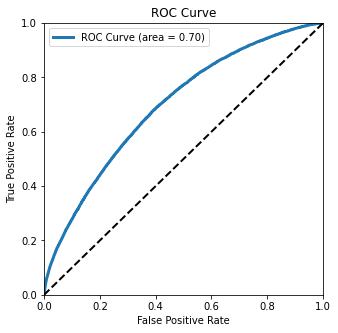

Reply
auc: 0.08570154727697853
rce: 9.809177655344214


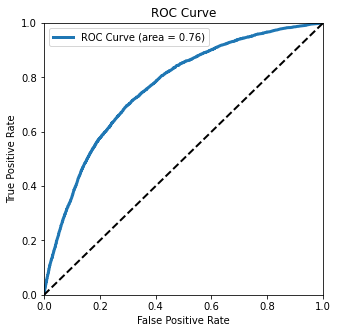

Like
auc: 0.6495522870994576
rce: 10.548180249415628


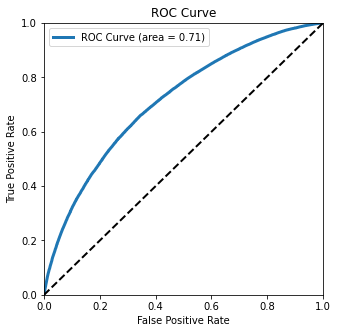

RTwCmnt
auc: 0.015371436237478562
rce: 2.870513317168577


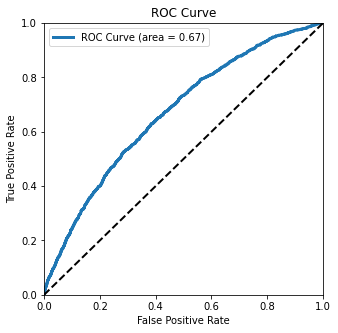

In [22]:
tgt2auc={}
tgt2rce={}
for i,tgt in enumerate(tgts):
    print(tgt)
    yval = tgt2yval[tgt]
    prdval = tgt2prdval[tgt]
    scr_auc=compute_prauc(prdval, yval)
    scr_rce=compute_rce(prdval, yval)
    tgt2auc[tgt]=scr_auc
    tgt2rce[tgt]=scr_rce
    print('auc:',scr_auc)
    print('rce:', scr_rce)
    show_roc(prdval, yval)

In [25]:
lst=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lst+=[(f'PRAUC {tgt}',tgt2auc[tgt]),
          (f'RCE {tgt}',tgt2rce[tgt])]

In [26]:
pd.DataFrame(lst).T

,0,1,2,3,4,5,6,7
0,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
1,0.238536,7.3893,0.0857015,9.80918,0.649552,10.5482,0.0153714,2.87051


# infer

In [27]:
# !head -1000000 {p_in}/val.tsv > {p_in}/val1e6.tsv

In [28]:
dftst=dd.read_csv(f'{p_in}/val1e6.tsv',
                  sep='\x01',
               header=None,
               names=cols_val,
               encoding='utf8')

In [29]:
%%time
Xtst, cols_feat = makeX(dftst)

CPU times: user 2.02 s, sys: 212 ms, total: 2.24 s
Wall time: 16.2 s


In [30]:
%%time
tgt2prdtst={}
for i,tgt in enumerate(tgts):
    prdtst = dask_xgboost.predict(client, tgt2bst[tgt], Xtst)
    prdtst = prdtst
    tgt2prdtst[tgt]=prdtst 

CPU times: user 7.41 ms, sys: 344 µs, total: 7.76 ms
Wall time: 6.11 ms


In [31]:
dfsub_ids = dftst[['tweet_id','engaged_user_id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [32]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{PRFX}.csv',index=False,header=False,single_file=True)

2020-03-15 19:52:49 Retweet
2020-03-15 19:53:02 Reply
2020-03-15 19:53:15 Like
2020-03-15 19:53:29 RTwCmnt
CPU times: user 4.69 s, sys: 491 ms, total: 5.18 s
Wall time: 53.3 s


In [ ]:
# %%time
# for tgt in tgts:
#     print(dtnow(), tgt)
#     dfsub = pd.concat(pd.read_csv(o, header=None) for o in sorted(glob.glob(f'{p_out}/{tgt}__{PRFX}_*.csv')))
#     dfsub.to_csv(f'{p_out}/{tgt}__{PRFX}.csv', 
#                           index=False, 
#                           header=False)

In [34]:
!head -n 2 {p_in}/val1e4.tsv

101	47185	10157	100986	10343	55422	119	14120	131	120	120	188	119	11170	120	162	10162	10575	10237	11281	10123	11305	11537	10350	10115	1027647B4E9DAF4C1D8973397DC2A04F3E3PhotoTopLevelD3164C7FBCF2565DDF915B1B3AEFB1DC15817031268A9AB92B775C62C4AB60DF6773A01571139411216false14482921860000006C3074607050F1339DDCB890BB27448600false1520948869true
101	6006	5086	1939	7418	3601	6406	1913	3800	21252	18767	2369	5322	8255	3671	14813	20058	4335	1912	22480	111814	18872	91872	108247	12236	5078	1923	11312	16838	15802	18825	60847	1881	1881	1881	4476	3740	65236	10898	103305	1881	1881	1881	1881	1881	1881	3102	77509	4726	1939	2195	2149	11592	15802	50508	52310	1881	1881	1881	1881	1881	1881	1881	14120	131	120	120	188	119	11170	120	153	10477	13034	12674	58123	10929	10410	102CCBFBA5AFE7EFC03102EA8D0F86C4208PhotoTopLevel22C448FF81263D4BAF2A176145EE9EAD1581736431187AC59639DA9A6F32F7CD118EDD58F74764391478false125444772200000776B07587ECA9717BFC301F2D6E102659false1478011810false


In [33]:
!head -n 2 {p_out}/Like__0315_1.csv

7647B4E9DAF4C1D8973397DC2A04F3E3,8A9AB92B775C62C4AB60DF6773A01571,0.5777477
CCBFBA5AFE7EFC03102EA8D0F86C4208,187AC59639DA9A6F32F7CD118EDD58F7,0.5494673
